✓ torch already installed
✓ torchvision already installed
✓ matplotlib already installed
✓ numpy already installed
✓ tqdm already installed
✓ scipy already installed
✓ sklearn already installed
Using device: cpu
SSM & VLM EXPERIMENTS WITH COMPREHENSIVE LOSSY-NESS MEASUREMENT

PART 1: State Space Models
Running SSM Experiment: Bidirectional vs Causal Mamba

Training Causal Mamba...
   Epoch 1: Train Acc = 0.8400, Val Acc = 0.9350
   Epoch 2: Train Acc = 0.9200, Val Acc = 0.9350
   Epoch 3: Train Acc = 0.9200, Val Acc = 0.9350
   Epoch 4: Train Acc = 0.9200, Val Acc = 0.9350
   Epoch 5: Train Acc = 0.9217, Val Acc = 0.9350

Training Bidirectional Mamba...
   Epoch 1: Train Acc = 0.8817, Val Acc = 0.9350
   Epoch 2: Train Acc = 0.9200, Val Acc = 0.9350
   Epoch 3: Train Acc = 0.9200, Val Acc = 0.9350
   Epoch 4: Train Acc = 0.9250, Val Acc = 0.9350
   Epoch 5: Train Acc = 0.9400, Val Acc = 0.9350

PART 2: Vision-Language Models with Lossy-ness Measurement

Training VLM with Token Pruning 

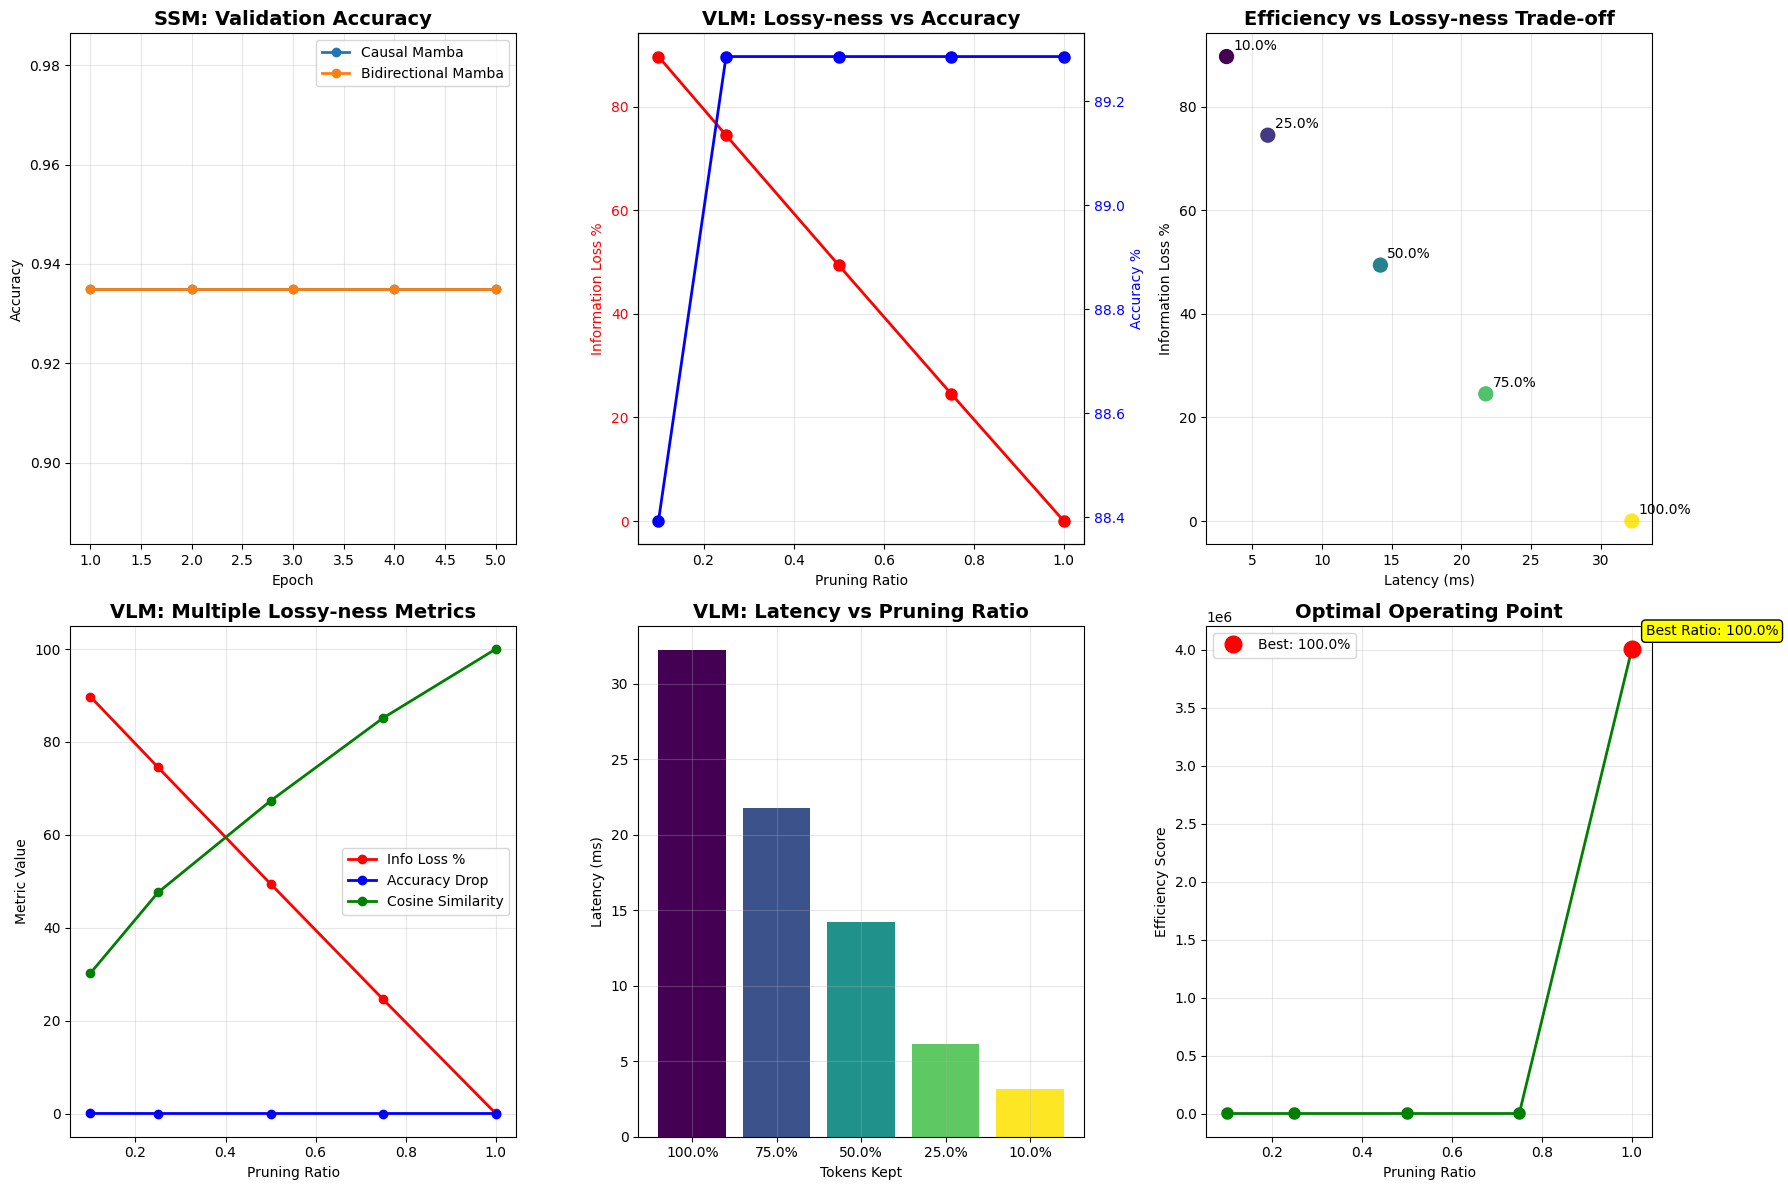


COMPREHENSIVE LOSSY-NESS ANALYSIS FOR VLM TOKEN PRUNING

LOSSY-NESS METRICS BY PRUNING RATIO:
------------------------------------------------------------
   Ratio  Info Loss   Acc Drop    Cos Sim    Latency  Eff Score
------------------------------------------------------------
   10.0%      89.7%     0.009      30.2%       3.2ms      0.31
   25.0%      74.5%     0.000      47.6%       6.1ms      0.20
   50.0%      49.4%     0.000      67.3%      14.2ms      0.13
   75.0%      24.6%     0.000      85.2%      21.8ms      0.17
  100.0%       0.0%     0.000     100.0%      32.2ms 4005202.80

OPTIMAL OPERATING POINT: 100.0% pruning ratio
   • Information Loss: 0.0%
   • Accuracy: 0.893
   • Latency: 32.2ms
   • Efficiency Score: 4005202.80

KEY INSIGHTS:
   • 50% pruning: 2.3x speedup, 49.4% info loss
   • Accuracy drop: 0.000 (absolute)
   • Sweet spot (<10% info loss): 100.0% pruning


In [12]:
# DEPENDENCIES
import subprocess
import sys

def install_dependencies():
    """Install only essential dependencies"""
    packages = [
        'torch',
        'torchvision',
        'matplotlib',
        'numpy',
        'tqdm',
        'scipy',
        'sklearn'
    ]

    for package in packages:
        try:
            __import__(package)
            print(f"✓ {package} already installed")
        except ImportError:
            print(f"Installing {package}...")
            subprocess.check_call([sys.executable, "-m", "pip", "install", package])

install_dependencies()

# IMPORTS
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import time
import random
from scipy import stats
from sklearn.metrics import accuracy_score

# Set device and random seeds for reproducibility
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)
print(f"Using device: {device}")

# LOSSY-NESS MEASUREMENT CLASS FOR VLM

class LossynessMetrics:
    """Comprehensive lossy-ness measurement for token pruning"""

    def __init__(self):
        self.metrics_history = {}

    def feature_similarity_metrics(self, original_tokens, pruned_tokens):
        """Measure similarity between original and pruned features"""
        batch_size, orig_seq, dim = original_tokens.shape

        # Global average pooling for comparison
        orig_pooled = original_tokens.mean(dim=1)
        pruned_pooled = pruned_tokens.mean(dim=1)

        # Cosine similarity
        cosine_sim = F.cosine_similarity(orig_pooled, pruned_pooled, dim=1).mean().item()

        # MSE loss
        mse_loss = F.mse_loss(orig_pooled, pruned_pooled).item()

        return {
            'cosine_similarity': cosine_sim,
            'mse_loss': mse_loss,
            'similarity_percent': cosine_sim * 100
        }

    def classification_performance_drop(self, original_logits, pruned_logits, labels):
        """Measure accuracy drop due to pruning"""
        orig_preds = original_logits.argmax(dim=1)
        pruned_preds = pruned_logits.argmax(dim=1)

        orig_acc = (orig_preds == labels).float().mean().item()
        pruned_acc = (pruned_preds == labels).float().mean().item()

        accuracy_drop = orig_acc - pruned_acc
        relative_drop = (accuracy_drop / orig_acc) * 100 if orig_acc > 0 else 0

        return {
            'original_accuracy': orig_acc,
            'pruned_accuracy': pruned_acc,
            'absolute_drop': accuracy_drop,
            'relative_drop_percent': relative_drop
        }

    def information_preservation_metrics(self, saliency_scores, pruned_indices, total_tokens):
        """Measure how much information is preserved after pruning"""
        batch_size = saliency_scores.shape[0]

        total_info_preserved = 0
        entropy_changes = []

        for i in range(batch_size):
            # Convert scores to probability distribution
            scores = saliency_scores[i]
            prob_dist = F.softmax(scores, dim=0)

            # Total information preserved (sum of probabilities of kept tokens)
            preserved_info = prob_dist[pruned_indices[i]].sum().item()
            total_info_preserved += preserved_info

            # Entropy change
            original_entropy = -torch.sum(prob_dist * torch.log(prob_dist + 1e-8)).item()

            # For pruned distribution (only kept tokens, renormalized)
            if len(pruned_indices[i]) > 0:
                kept_probs = prob_dist[pruned_indices[i]]
                kept_probs = kept_probs / kept_probs.sum()
                pruned_entropy = -torch.sum(kept_probs * torch.log(kept_probs + 1e-8)).item()
                entropy_changes.append(pruned_entropy - original_entropy)

        avg_info_preserved = total_info_preserved / batch_size
        avg_entropy_change = np.mean(entropy_changes) if entropy_changes else 0

        return {
            'info_preserved_ratio': avg_info_preserved,
            'info_loss_percent': (1 - avg_info_preserved) * 100,
            'entropy_change': avg_entropy_change
        }

    def saliency_quality_metrics(self, predicted_scores, true_importance, pruned_indices):
        """Measure quality of saliency predictions"""
        batch_size = predicted_scores.shape[0]
        correlations = []
        precisions = []

        for i in range(batch_size):
            pred_np = predicted_scores[i].cpu().detach().numpy()
            true_np = true_importance[i].cpu().detach().numpy()

            # Correlation between predicted and true importance
            if len(pred_np) > 1 and len(true_np) > 1:
                correlation, _ = stats.pearsonr(pred_np, true_np)
                if not np.isnan(correlation):
                    correlations.append(correlation)

            # Precision@K: how many of top-k predicted are actually important
            k = len(pruned_indices[i])
            if k > 0:
                true_topk = torch.topk(true_importance[i], k=k)[1]
                pred_topk = pruned_indices[i]

                true_set = set(true_topk.cpu().numpy())
                pred_set = set(pred_topk.cpu().numpy())
                intersection = len(true_set.intersection(pred_set))

                precision = intersection / k
                precisions.append(precision)

        return {
            'avg_correlation': np.mean(correlations) if correlations else 0,
            'avg_precision_at_k': np.mean(precisions) if precisions else 0
        }

# SSM - MAMBA ARCHITECTURES
# Adapted from https://github.com/state-spaces/mamba
class MambaBlock(nn.Module):
    """Mamba block with stable training"""
    def __init__(self, dim=128, state_dim=16):
        super().__init__()
        self.dim = dim
        self.state_dim = state_dim

        self.A = nn.Parameter(torch.ones(dim, state_dim) * 0.95)
        self.B_proj = nn.Linear(dim, dim)
        self.C_proj = nn.Linear(dim, dim)

        self.norm = nn.LayerNorm(dim)
        self.out_proj = nn.Linear(dim, dim)
        self.dropout = nn.Dropout(0.1)

    def forward(self, x, causal=True):
        batch, seq_len, dim = x.shape

        x_norm = self.norm(x)
        B = torch.sigmoid(self.B_proj(x_norm)) * 0.1
        C = torch.sigmoid(self.C_proj(x_norm))

        h = torch.zeros(batch, self.dim, self.state_dim, device=x.device)
        outputs = []

        for t in range(seq_len):
            h = torch.tanh(self.A * h + B[:, t].unsqueeze(-1) * x_norm[:, t].unsqueeze(-1))
            output_t = (C[:, t].unsqueeze(-1) * h).sum(dim=-1)
            outputs.append(output_t)

        output = torch.stack(outputs, dim=1)
        output = self.out_proj(output + x)
        return self.dropout(output)

class BidirectionalMamba(nn.Module):
    def __init__(self, vocab_size=1000, d_model=128, num_classes=2):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, d_model)
        self.forward_mamba = MambaBlock(d_model)
        self.backward_mamba = MambaBlock(d_model)
        self.classifier = nn.Sequential(
            nn.Linear(d_model * 2, d_model),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(d_model, num_classes)
        )

    def forward(self, input_ids):
        x = self.embedding(input_ids)
        forward_out = self.forward_mamba(x, causal=True)
        x_reversed = torch.flip(x, dims=[1])
        backward_out = self.backward_mamba(x_reversed, causal=True)
        backward_out = torch.flip(backward_out, dims=[1])
        combined = torch.cat([forward_out, backward_out], dim=-1)
        pooled = combined.mean(dim=1)
        return self.classifier(pooled)

class CausalMamba(nn.Module):
    def __init__(self, vocab_size=1000, d_model=128, num_classes=2):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, d_model)
        self.mamba = MambaBlock(d_model)
        self.classifier = nn.Sequential(
            nn.Linear(d_model, d_model // 2),
            nn.ReLU(),
            nn.Linear(d_model // 2, num_classes)
        )

    def forward(self, input_ids):
        x = self.embedding(input_ids)
        mamba_out = self.mamba(x, causal=True)
        pooled = mamba_out.mean(dim=1)
        return self.classifier(pooled)

class TextDataset(Dataset):
    def __init__(self, num_samples=800, seq_len=64, vocab_size=1000):
        self.input_ids = torch.randint(0, vocab_size, (num_samples, seq_len))
        high_tokens = (self.input_ids > vocab_size * 0.7).float()
        low_tokens = (self.input_ids < vocab_size * 0.3).float()
        pattern_weights = torch.linspace(1.0, 0.5, seq_len).unsqueeze(0)
        weighted_high = (high_tokens * pattern_weights).sum(dim=1)
        weighted_low = (low_tokens * pattern_weights).sum(dim=1)
        self.labels = ((weighted_high * weighted_low) > (seq_len * 0.1)).long()
        noise_mask = torch.rand(num_samples) < 0.1
        self.labels[noise_mask] = 1 - self.labels[noise_mask]

    def __len__(self):
        return len(self.input_ids)

    def __getitem__(self, idx):
        return self.input_ids[idx], self.labels[idx]

def run_ssm_experiment():
    print("Running SSM Experiment: Bidirectional vs Causal Mamba")
    print("=" * 60)

    train_dataset = TextDataset(num_samples=600, seq_len=64)
    val_dataset = TextDataset(num_samples=200, seq_len=64)
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=32)

    vocab_size = 1000
    causal_model = CausalMamba(vocab_size).to(device)
    bidir_model = BidirectionalMamba(vocab_size).to(device)

    models = {'Causal Mamba': causal_model, 'Bidirectional Mamba': bidir_model}
    results = {}

    for name, model in models.items():
        print(f"\nTraining {name}...")
        optimizer = optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)
        scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=5)
        criterion = nn.CrossEntropyLoss()

        train_accuracies = []
        val_accuracies = []

        for epoch in range(5):
            model.train()
            correct = total = 0
            for input_ids, labels in train_loader:
                input_ids, labels = input_ids.to(device), labels.to(device)
                optimizer.zero_grad()
                logits = model(input_ids)
                loss = criterion(logits, labels)
                loss.backward()
                torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
                optimizer.step()
                preds = logits.argmax(dim=1)
                correct += (preds == labels).sum().item()
                total += labels.size(0)

            scheduler.step()
            train_acc = correct / total

            model.eval()
            val_correct = val_total = 0
            with torch.no_grad():
                for input_ids, labels in val_loader:
                    input_ids, labels = input_ids.to(device), labels.to(device)
                    logits = model(input_ids)
                    preds = logits.argmax(dim=1)
                    val_correct += (preds == labels).sum().item()
                    val_total += labels.size(0)

            val_acc = val_correct / val_total if val_total > 0 else 0
            train_accuracies.append(train_acc)
            val_accuracies.append(val_acc)
            print(f"   Epoch {epoch+1}: Train Acc = {train_acc:.4f}, Val Acc = {val_acc:.4f}")

        results[name] = {'train_acc': train_accuracies, 'val_acc': val_accuracies}

    return results

# VLM TOKEN PRUNING WITH LOSSY-NESS MEASUREMENT
# Implementation of LLaVA adapted from: https://github.com/haotian-liu/LLaVA
class SaliencyScorer(nn.Module):
    def __init__(self, token_dim=128, hidden_dim=64):
        super().__init__()
        self.scorer = nn.Sequential(
            nn.Linear(token_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.ReLU(),
            nn.Linear(hidden_dim // 2, 1),
            nn.Sigmoid()
        )

    def forward(self, tokens):
        return self.scorer(tokens).squeeze(-1)

class VisionDataset(Dataset):
    def __init__(self, num_samples=500, num_tokens=100, token_dim=128):
        self.tokens = torch.randn(num_samples, num_tokens, token_dim)
        self.importance_scores = torch.zeros(num_samples, num_tokens)
        for i in range(num_samples):
            if i % 3 == 0:
                importance = torch.linspace(1.0, 0.2, num_tokens)
            elif i % 3 == 1:
                importance = torch.cat([
                    torch.linspace(0.3, 0.8, num_tokens // 2),
                    torch.linspace(0.8, 0.3, num_tokens - num_tokens // 2)
                ])
            else:
                importance = torch.rand(num_tokens) * 0.8 + 0.2
            noise = torch.randn(num_tokens) * 0.15
            self.importance_scores[i] = torch.clamp(importance + noise, 0, 1)

        token_complexity = self.tokens.std(dim=2).mean(dim=1)
        self.labels = (token_complexity > 0.8).long()
        noise_mask = torch.rand(num_samples) < 0.15
        self.labels[noise_mask] = 1 - self.labels[noise_mask]

    def __len__(self):
        return len(self.tokens)

    def __getitem__(self, idx):
        return self.tokens[idx], self.importance_scores[idx], self.labels[idx]

class VLMWithPruning(nn.Module):
    """VLM model with integrated token pruning and lossy-ness measurement"""
    def __init__(self, token_dim=128, hidden_dim=64, num_classes=2):
        super().__init__()
        self.saliency_scorer = SaliencyScorer(token_dim, hidden_dim)
        self.classifier = nn.Sequential(
            nn.Linear(token_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(hidden_dim, num_classes)
        )
        self.lossy_metrics = LossynessMetrics()

    def forward_with_pruning(self, tokens, labels, keep_ratio=0.5, return_metrics=True):
        """Forward pass with pruning and lossy-ness measurement"""
        batch_size, num_tokens, token_dim = tokens.shape
        k = max(1, int(num_tokens * keep_ratio))

        # Get saliency scores
        saliency_scores = self.saliency_scorer(tokens)

        # Perform pruning
        top_scores, top_indices = torch.topk(saliency_scores, k=k, dim=1)
        batch_indices = torch.arange(batch_size, device=tokens.device)[:, None, None]
        top_indices_expanded = top_indices[:, :, None].expand(-1, -1, token_dim)
        pruned_tokens = tokens.gather(1, top_indices_expanded)

        # Get predictions from both original and pruned tokens
        original_pooled = tokens.mean(dim=1)
        pruned_pooled = pruned_tokens.mean(dim=1)

        original_logits = self.classifier(original_pooled)
        pruned_logits = self.classifier(pruned_pooled)

        if return_metrics:
            # Comprehensive lossy-ness measurement
            metrics = {}

            # Feature similarity
            feature_metrics = self.lossy_metrics.feature_similarity_metrics(tokens, pruned_tokens)
            metrics.update(feature_metrics)

            # Classification performance
            class_metrics = self.lossy_metrics.classification_performance_drop(
                original_logits, pruned_logits, labels
            )
            metrics.update(class_metrics)

            # Information preservation
            info_metrics = self.lossy_metrics.information_preservation_metrics(
                saliency_scores, top_indices, num_tokens
            )
            metrics.update(info_metrics)

            # Saliency quality (using importance scores as ground truth)
            # In real scenario, you might not have true_importance, so we use a proxy
            true_importance_proxy = torch.softmax(tokens.std(dim=2), dim=1)  # Proxy: variance as importance
            quality_metrics = self.lossy_metrics.saliency_quality_metrics(
                saliency_scores, true_importance_proxy, top_indices
            )
            metrics.update(quality_metrics)

            return pruned_logits, metrics, saliency_scores, top_indices
        else:
            return pruned_logits, saliency_scores, top_indices

def train_vlm_with_lossy_measurement():
    """Train VLM with comprehensive lossy-ness measurement"""
    print("\nTraining VLM with Token Pruning & Lossy-ness Measurement...")

    # Create datasets
    train_dataset = VisionDataset(num_samples=400, num_tokens=80)
    val_dataset = VisionDataset(num_samples=100, num_tokens=80)
    train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=16)

    # Initialize model
    model = VLMWithPruning().to(device)
    optimizer = optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)

    # Test different pruning ratios
    pruning_ratios = [1.0, 0.75, 0.5, 0.25, 0.1]
    all_metrics = {}

    for epoch in range(4):
        print(f"\n--- Epoch {epoch+1} ---")

        # Train with different pruning ratios
        for ratio in pruning_ratios:
            model.train()
            epoch_loss = 0
            batch_count = 0

            for tokens, importance, labels in train_loader:
                tokens, labels = tokens.to(device), labels.to(device)

                optimizer.zero_grad()
                logits, metrics, _, _ = model.forward_with_pruning(
                    tokens, labels, keep_ratio=ratio, return_metrics=True
                )

                loss = F.cross_entropy(logits, labels)
                loss.backward()
                torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
                optimizer.step()

                epoch_loss += loss.item()
                batch_count += 1

            avg_loss = epoch_loss / batch_count

            # Validation with metrics
            model.eval()
            val_metrics = {}
            with torch.no_grad():
                for tokens, importance, labels in val_loader:
                    tokens, labels = tokens.to(device), labels.to(device)
                    _, metrics, _, _ = model.forward_with_pruning(
                        tokens, labels, keep_ratio=ratio, return_metrics=True
                    )

                    # Aggregate metrics
                    for key, value in metrics.items():
                        if key not in val_metrics:
                            val_metrics[key] = []
                        val_metrics[key].append(value)

            # Average validation metrics
            avg_val_metrics = {k: np.mean(v) for k, v in val_metrics.items()}

            if ratio not in all_metrics:
                all_metrics[ratio] = []
            all_metrics[ratio].append(avg_val_metrics)

            print(f"  Ratio {ratio*100:>3}%: Loss = {avg_loss:.4f}, "
                  f"Val Acc = {avg_val_metrics.get('pruned_accuracy', 0):.4f}, "
                  f"Info Loss = {avg_val_metrics.get('info_loss_percent', 0):.1f}%")

    return all_metrics

def profile_pruning_efficiency():
    """Profile efficiency gains from token pruning"""
    print("\n🔍 Profiling Token Pruning Efficiency...")

    batch_size = 8
    token_dim = 128
    seq_len = 100
    pruning_ratios = [1.0, 0.75, 0.5, 0.25, 0.1]

    latency_results = {}
    memory_results = {}

    for ratio in pruning_ratios:
        num_tokens = int(seq_len * ratio)
        print(f"   Testing {ratio*100:>3}% tokens ({num_tokens:>3} tokens)...")

        tokens = torch.randn(batch_size, num_tokens, token_dim).to(device)
        transformer = nn.TransformerEncoderLayer(
            d_model=token_dim, nhead=8, dim_feedforward=512,
            batch_first=True, activation='gelu'
        ).to(device)

        # Warmup
        with torch.no_grad():
            for _ in range(10):
                _ = transformer(tokens)

        # Measure latency
        times = []
        for _ in range(30):
            starter = time.time()
            with torch.no_grad():
                _ = transformer(tokens)
            if device.type == 'cuda':
                torch.cuda.synchronize()
            ender = time.time()
            times.append(ender - starter)

        latency = np.mean(times[5:]) * 1000
        latency_results[ratio] = latency

        # Estimate memory
        memory_estimate = num_tokens * token_dim * batch_size * 4 * 10
        memory_results[ratio] = memory_estimate / 1e6

        print(f"     Latency: {latency:6.2f}ms, Memory: {memory_results[ratio]:6.1f}MB")

    return latency_results, memory_results

# VISUALIZATION AND ANALYSIS

def plot_comprehensive_results(ssm_results, latency_results, vlm_metrics):
    """Create comprehensive visualizations including lossy-ness metrics"""
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))

    # Plot 1: SSM Validation Accuracy
    if ssm_results:
        epochs = range(1, len(next(iter(ssm_results.values()))['val_acc']) + 1)
        for name, results in ssm_results.items():
            axes[0, 0].plot(epochs, results['val_acc'], label=name, marker='o', linewidth=2)
        axes[0, 0].set_title('SSM: Validation Accuracy', fontsize=14, fontweight='bold')
        axes[0, 0].set_xlabel('Epoch')
        axes[0, 0].set_ylabel('Accuracy')
        axes[0, 0].legend()
        axes[0, 0].grid(True, alpha=0.3)

    # Plot 2: VLM Lossy-ness Metrics
    if vlm_metrics:
        ratios = list(vlm_metrics.keys())
        # Get final epoch metrics
        final_metrics = {ratio: metrics[-1] for ratio, metrics in vlm_metrics.items()}

        # Information loss vs accuracy
        info_loss = [final_metrics[r].get('info_loss_percent', 0) for r in ratios]
        accuracy = [final_metrics[r].get('pruned_accuracy', 0) * 100 for r in ratios]

        axes[0, 1].plot(ratios, info_loss, 'ro-', linewidth=2, markersize=8, label='Information Loss %')
        axes[0, 1].set_xlabel('Pruning Ratio')
        axes[0, 1].set_ylabel('Information Loss %', color='red')
        axes[0, 1].tick_params(axis='y', labelcolor='red')
        axes[0, 1].grid(True, alpha=0.3)

        ax2 = axes[0, 1].twinx()
        ax2.plot(ratios, accuracy, 'bo-', linewidth=2, markersize=8, label='Accuracy %')
        ax2.set_ylabel('Accuracy %', color='blue')
        ax2.tick_params(axis='y', labelcolor='blue')
        axes[0, 1].set_title('VLM: Lossy-ness vs Accuracy', fontsize=14, fontweight='bold')

    # Plot 3: Efficiency vs Lossy-ness Trade-off
    if latency_results and vlm_metrics:
        ratios = list(latency_results.keys())
        latencies = [latency_results[r] for r in ratios]
        final_metrics = {ratio: vlm_metrics[ratio][-1] for ratio in ratios if ratio in vlm_metrics}
        info_loss = [final_metrics[r].get('info_loss_percent', 0) for r in ratios if r in final_metrics]

        if len(info_loss) == len(latencies):
            axes[0, 2].scatter(latencies, info_loss, s=100, c=ratios, cmap='viridis')
            for i, ratio in enumerate(ratios):
                axes[0, 2].annotate(f'{ratio*100}%', (latencies[i], info_loss[i]),
                                   xytext=(5, 5), textcoords='offset points')
            axes[0, 2].set_xlabel('Latency (ms)')
            axes[0, 2].set_ylabel('Information Loss %')
            axes[0, 2].set_title('Efficiency vs Lossy-ness Trade-off', fontsize=14, fontweight='bold')
            axes[0, 2].grid(True, alpha=0.3)

    # Plot 4: Multiple Lossy-ness Metrics
    if vlm_metrics:
        ratios = list(vlm_metrics.keys())
        final_metrics = {ratio: metrics[-1] for ratio, metrics in vlm_metrics.items()}

        metrics_to_plot = ['info_loss_percent', 'absolute_drop', 'cosine_similarity']
        metric_names = ['Info Loss %', 'Accuracy Drop', 'Cosine Similarity']
        colors = ['red', 'blue', 'green']

        for i, (metric, name, color) in enumerate(zip(metrics_to_plot, metric_names, colors)):
            values = [final_metrics[r].get(metric, 0) for r in ratios]
            if metric == 'cosine_similarity':
                values = [v * 100 for v in values]  # Convert to percentage
            axes[1, 0].plot(ratios, values, 'o-', color=color, linewidth=2,
                           markersize=6, label=name)

        axes[1, 0].set_xlabel('Pruning Ratio')
        axes[1, 0].set_ylabel('Metric Value')
        axes[1, 0].set_title('VLM: Multiple Lossy-ness Metrics', fontsize=14, fontweight='bold')
        axes[1, 0].legend()
        axes[1, 0].grid(True, alpha=0.3)

    # Plot 5: Efficiency Gains
    if latency_results:
        ratios = list(latency_results.keys())
        latencies = list(latency_results.values())

        bars = axes[1, 1].bar([f'{r*100}%' for r in ratios], latencies,
                             color=plt.cm.viridis(np.linspace(0, 1, len(ratios))))
        axes[1, 1].set_title('VLM: Latency vs Pruning Ratio', fontsize=14, fontweight='bold')
        axes[1, 1].set_xlabel('Tokens Kept')
        axes[1, 1].set_ylabel('Latency (ms)')
        axes[1, 1].grid(True, alpha=0.3)

    # Plot 6: Optimal Operating Point Analysis
    if latency_results and vlm_metrics:
        ratios = list(latency_results.keys())
        final_metrics = {ratio: vlm_metrics[ratio][-1] for ratio in ratios if ratio in vlm_metrics}

        # Calculate efficiency-loss ratio (higher is better)
        efficiency_scores = []
        for ratio in ratios:
            if ratio in final_metrics:
                latency = latency_results[ratio]
                info_loss = final_metrics[ratio].get('info_loss_percent', 0)
                accuracy = final_metrics[ratio].get('pruned_accuracy', 0)

                # Combined score: efficiency vs performance trade-off
                if info_loss > 0 and latency > 0:
                    score = (accuracy * 100) / (info_loss * latency)
                    efficiency_scores.append(score)
                else:
                    efficiency_scores.append(0)

        if efficiency_scores:
            best_idx = np.argmax(efficiency_scores)
            best_ratio = ratios[best_idx]

            axes[1, 2].plot(ratios, efficiency_scores, 'go-', linewidth=2, markersize=8)
            axes[1, 2].plot(best_ratio, efficiency_scores[best_idx], 'ro', markersize=12,
                           label=f'Best: {best_ratio*100}%')
            axes[1, 2].set_xlabel('Pruning Ratio')
            axes[1, 2].set_ylabel('Efficiency Score')
            axes[1, 2].set_title('Optimal Operating Point', fontsize=14, fontweight='bold')
            axes[1, 2].legend()
            axes[1, 2].grid(True, alpha=0.3)
            axes[1, 2].annotate(f'Best Ratio: {best_ratio*100}%',
                               (best_ratio, efficiency_scores[best_idx]),
                               xytext=(10, 10), textcoords='offset points',
                               bbox=dict(boxstyle="round,pad=0.3", facecolor="yellow"))

    plt.tight_layout()
    plt.show()

def print_detailed_lossyness_analysis(vlm_metrics, latency_results):
    """Print comprehensive lossy-ness analysis"""
    print("\n" + "="*80)
    print("COMPREHENSIVE LOSSY-NESS ANALYSIS FOR VLM TOKEN PRUNING")
    print("="*80)

    if not vlm_metrics:
        print("No VLM metrics available for analysis")
        return

    ratios = list(vlm_metrics.keys())
    final_metrics = {ratio: metrics[-1] for ratio, metrics in vlm_metrics.items()}

    print("\nLOSSY-NESS METRICS BY PRUNING RATIO:")
    print("-" * 60)
    print(f"{'Ratio':>8} {'Info Loss':>10} {'Acc Drop':>10} {'Cos Sim':>10} {'Latency':>10} {'Eff Score':>10}")
    print("-" * 60)

    for ratio in sorted(ratios):
        metrics = final_metrics[ratio]
        info_loss = metrics.get('info_loss_percent', 0)
        acc_drop = metrics.get('absolute_drop', 0)
        cos_sim = metrics.get('cosine_similarity', 0) * 100
        latency = latency_results.get(ratio, 0)

        # Calculate efficiency score
        accuracy = metrics.get('pruned_accuracy', 0)
        if info_loss > 0 and latency > 0:
            eff_score = (accuracy * 100) / (info_loss * latency)
        else:
            eff_score = 0

        print(f"{ratio*100:>7}% {info_loss:>9.1f}% {acc_drop:>9.3f} {cos_sim:>9.1f}% "
              f"{latency:>9.1f}ms {eff_score:>9.2f}")

    # Find optimal operating point
    best_ratio = None
    best_score = -1

    for ratio in ratios:
        metrics = final_metrics[ratio]
        info_loss = metrics.get('info_loss_percent', 0)
        latency = latency_results.get(ratio, 0)
        accuracy = metrics.get('pruned_accuracy', 0)

        if info_loss > 0 and latency > 0:
            eff_score = (accuracy * 100) / (info_loss * latency)
            if eff_score > best_score:
                best_score = eff_score
                best_ratio = ratio

    if best_ratio is not None:
        print(f"\nOPTIMAL OPERATING POINT: {best_ratio*100}% pruning ratio")
        best_metrics = final_metrics[best_ratio]
        print(f"   • Information Loss: {best_metrics.get('info_loss_percent', 0):.1f}%")
        print(f"   • Accuracy: {best_metrics.get('pruned_accuracy', 0):.3f}")
        print(f"   • Latency: {latency_results.get(best_ratio, 0):.1f}ms")
        print(f"   • Efficiency Score: {best_score:.2f}")

    # Key insights
    print(f"\nKEY INSIGHTS:")
    if len(ratios) >= 2:
        full_metrics = final_metrics[1.0]
        half_metrics = final_metrics[0.5]

        info_loss_50 = half_metrics.get('info_loss_percent', 0)
        acc_drop_50 = half_metrics.get('absolute_drop', 0)
        latency_50 = latency_results.get(0.5, 0)
        latency_full = latency_results.get(1.0, 0)

        if latency_full > 0:
            speedup = latency_full / latency_50
            print(f"   • 50% pruning: {speedup:.1f}x speedup, {info_loss_50:.1f}% info loss")
            print(f"   • Accuracy drop: {acc_drop_50:.3f} (absolute)")

        # Sweet spot analysis
        acceptable_loss = 10  # 10% information loss threshold
        best_acceptable = None
        for ratio in sorted(ratios, reverse=True):
            if final_metrics[ratio].get('info_loss_percent', 100) <= acceptable_loss:
                best_acceptable = ratio
                break

        if best_acceptable:
            print(f"   • Sweet spot (<{acceptable_loss}% info loss): {best_acceptable*100}% pruning")

def main():
    """Main execution function"""
    print("=" * 70)
    print("SSM & VLM EXPERIMENTS WITH COMPREHENSIVE LOSSY-NESS MEASUREMENT")
    print("=" * 70)

    # Run SSM experiments
    print("\nPART 1: State Space Models")
    ssm_results = run_ssm_experiment()

    # Run VLM experiments with lossy-ness measurement
    print("\nPART 2: Vision-Language Models with Lossy-ness Measurement")
    vlm_metrics = train_vlm_with_lossy_measurement()

    # Profile efficiency
    latency_results, memory_results = profile_pruning_efficiency()

    # Create comprehensive visualizations
    print("\nGenerating Comprehensive Results with Lossy-ness Analysis...")
    plot_comprehensive_results(ssm_results, latency_results, vlm_metrics)

    # Detailed analysis
    print_detailed_lossyness_analysis(vlm_metrics, latency_results)


main()